## https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

In [3]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [66]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive, HoltWinters
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse, rel_mse, mqloss
from hierarchicalforecast.methods import TopDown, BottomUp
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.preprocessing import fill_gaps
import numpy as np

import pickle
from datetime import date, datetime
from sklearn.metrics import mean_absolute_percentage_error
from qgridnext import show_grid
from importlib import reload
import re

In [5]:
TEST_PERIODS = 2

In [6]:
Y_df_load = (
    pd.read_parquet("test_train_data.parquet").reset_index()
)
 
Y_df_load["y"] = (
    Y_df_load["y"] / 1e6
)  # make everything in millions so its easier to read

## Prep Data

In [7]:
# last date
last_date = pd.to_datetime(date(2024, 9, 30))

In [8]:
# XBRL data starts ~2010
first_date = pd.to_datetime(date(2010, 1, 1))

In [9]:
# remove periods after the date from which we are predicting
Y_df_load = Y_df_load[Y_df_load["ds"] <= last_date]
Y_df_load = Y_df_load[Y_df_load["ds"] >= first_date]

In [10]:
# remove companies for which we do not have current data
Y_df_load = Y_df_load.groupby("ticker").filter(lambda x: x["ds"].max() == last_date)

In [11]:
# Get rid of companies for which we do not have enough data
MINIMUM_NUMBER_OF_OBSERVATIONS = 40
Y_df_load = Y_df_load.groupby("ticker").filter(
    lambda x: x.shape[0] > MINIMUM_NUMBER_OF_OBSERVATIONS
)

In [12]:
pivot_columns = [
    "ticker",
    "top_level_SIC_code",
    "second_level_SIC_code",
    "third_level_SIC_code",
    "fourth_level_SIC_code",
]

In [13]:
# forward fill missing data
Y_df_load = (
    Y_df_load.pivot(
        index="ds",
        columns=pivot_columns,
        values="y",
    )
    .ffill()
    .melt(ignore_index=False, value_name="y")
    .reset_index()
)

In [14]:
Y_df_load = Y_df_load[~Y_df_load["y"].isna()]

In [15]:
Y_df_load["entity_type"] = "company"

## Build training data

In [16]:
levels = [
    ["entity_type", "top_level_SIC_code", "second_level_SIC_code"],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
    ],
    [
        "entity_type",
        "top_level_SIC_code",
        "second_level_SIC_code",
        "third_level_SIC_code",
        "fourth_level_SIC_code",
        "ticker",
    ],
]


levels = [
    ["entity_type"],
    ["entity_type", "top_level_SIC_code"],
    ["entity_type", "top_level_SIC_code", "ticker"],
]

levels = [
    ["top_level_SIC_code"],
    ["top_level_SIC_code", "second_level_SIC_code"],
    ["top_level_SIC_code", "second_level_SIC_code", "ticker"],
]

In [17]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=levels)

In [18]:
Y_df = Y_df.reset_index()

In [19]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [20]:
fcst = StatsForecast(models=[AutoARIMA(season_length=4), Naive()], freq="QE", n_jobs=-1)

In [21]:
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=TEST_PERIODS,
    fitted=True,
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [22]:
Y_hat_df

,ds,AutoARIMA,Naive
unique_id,,,
0,2024-06-30,5633.861816,4609.249023
0,2024-09-30,6986.506836,4609.249023
0/1,2024-06-30,4774.217773,3761.885986
0/1,2024-09-30,6163.367676,3761.885986
0/1/ALCO,2024-06-30,41.700409,13.985000
...,...,...,...
8/7/WHLM,2024-09-30,3.763000,3.763000
8/9,2024-06-30,536.212524,528.815979
8/9,2024-09-30,542.842163,528.815979


C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


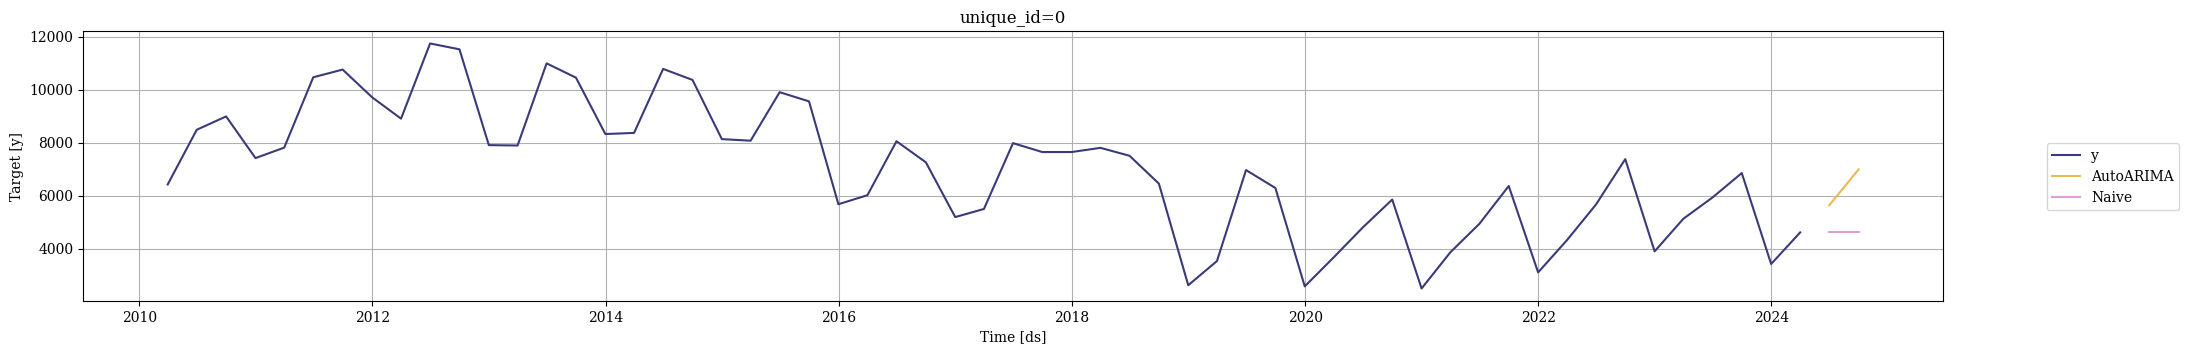

In [23]:
fcst.plot(
    Y_train_df,
    Y_hat_df,
    models=["AutoARIMA", "Naive"],
    unique_ids=["0"],
)

## Hierarchical reconciliation

In [24]:
hrec = HierarchicalReconciliation(reconcilers=[BottomUp()])

In [25]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

In [26]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

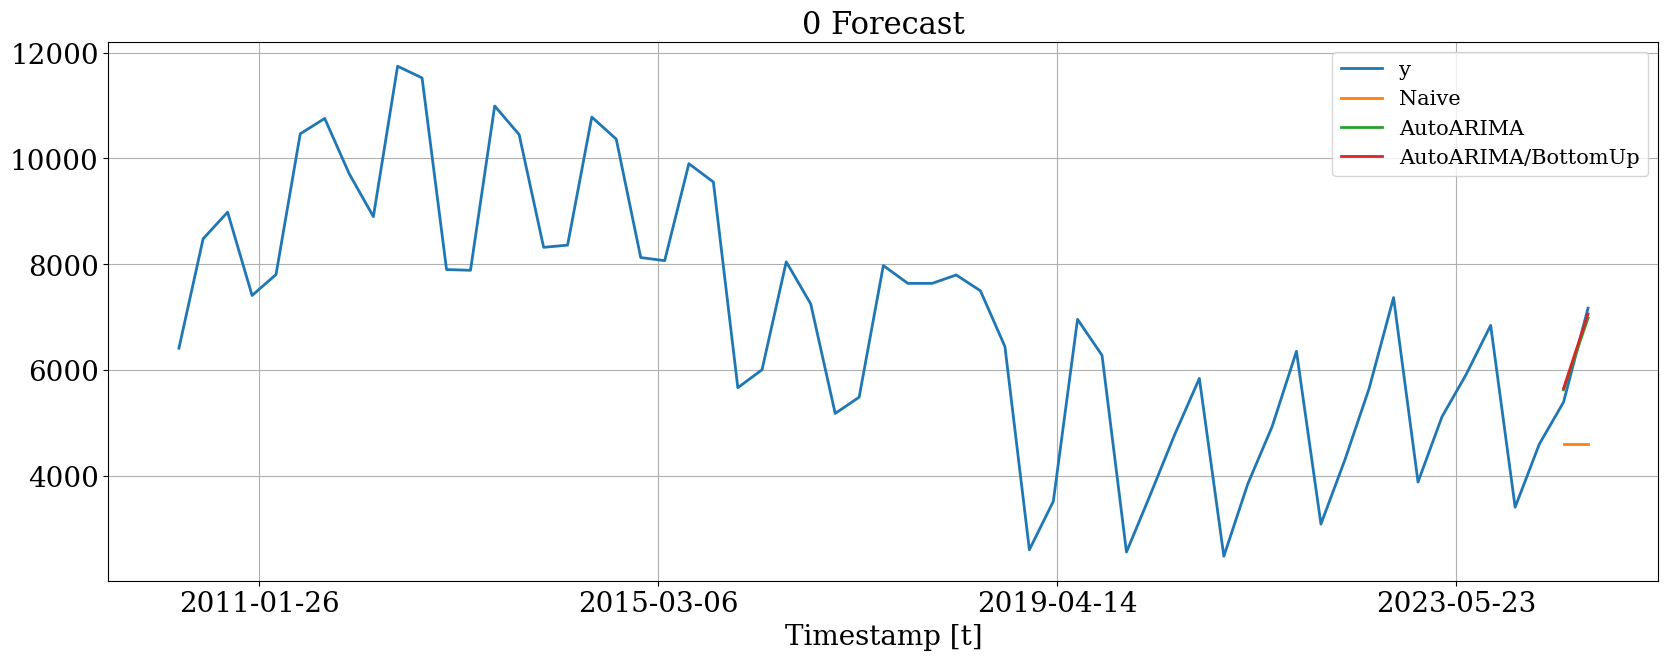

In [27]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_series(
    series="0",
    Y_df=plot_df,
    models=[
        "y",
        "Naive",
        "AutoARIMA",
        "AutoARIMA/BottomUp",
    ],
    level=[80],
)

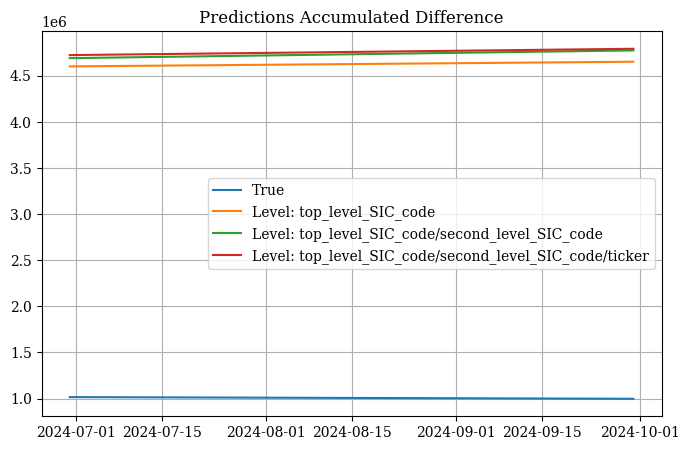

In [55]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
difference_df = Y_hat_df.merge(Y_test_df, on=["unique_id", "ds"])[
    ["ds", "AutoARIMA", "y"]
]

# hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

hplot.plot_hierarchical_predictions_gap(difference_df)

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [50]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    tags=tags,
    benchmark="AutoARIMA",
)

In [91]:
show_grid(
    Y_rec_df.set_index(["ds"], append=True)
    .sub(Y_test_df.set_index(["ds"], append=True)["y"], axis="index")[
        ["AutoARIMA", "AutoARIMA/BottomUp"]
    ]
    .query('ds == "2024-06-30"')
)

C:\Users\andre\AppData\Local\Temp\ipykernel_1128\3172211485.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  )[["AutoARIMA", "AutoARIMA/BottomUp"]].query('ds == "2024-06-30"')


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [67]:
Y_test_df['ds'] == datetime(2024, 6, 3)

unique_id
0           False
0           False
1           False
1           False
2           False
            ...  
8/7/VSEC    False
8/7/WHLM    False
8/7/WHLM    False
8/9/NVRI    False
8/9/NVRI    False
Name: ds, Length: 5438, dtype: bool